In [1]:
import numpy as np
import pandas as pd
import os
import librosa
import scipy
from scipy.stats import skew
from tqdm import tqdm, tqdm_pandas
tqdm.pandas()

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.svm import SVC
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Import Data

In [4]:
#loading data
audio_train_files = os.listdir('./input/train')
audio_test_files = os.listdir('./input/test')

In [3]:
audio_train_files

['American_bull',
 'Brauer_treefrog',
 'Brown_treefrog',
 'Butler',
 'Chinese_bull',
 'Eiffinger',
 'Emerald_treefrog',
 'Farmland_treefrog',
 'Fujian',
 'Green_pond',
 'Gunther',
 'Harpist',
 'Heymon',
 'Japanese_Buerger',
 'Latouchte',
 'Long-legged',
 'Malaysian_narrow_mouthed_toad',
 'Mangrove',
 'Meintein_treefrog',
 'Moltrecht_treefrog',
 'Olive',
 'Orange_belly_treefrog',
 'Ornate_rice',
 'Ota_treefrog',
 'Rice_field',
 'Sauter',
 'Spot_legged_treefrog',
 'Stejneger',
 'Swinhoe',
 'Taipei_grass',
 'Taipei_treefrog',
 'Wang_treefrog']

In [8]:
import librosa
import librosa.display 
SAMPLE_RATE = 44100

In [13]:
fname = './input/train/Butler/Butler_1.mp3'
mp3, _ = librosa.core.load(fname, sr=SAMPLE_RATE)

In [14]:
mp3.shape

(308207,)

In [15]:
mp3

array([ 6.1035156e-05,  9.1552734e-05,  3.0517578e-05, ...,
       -7.8842163e-02, -4.2724609e-02,  1.1337280e-02], dtype=float32)

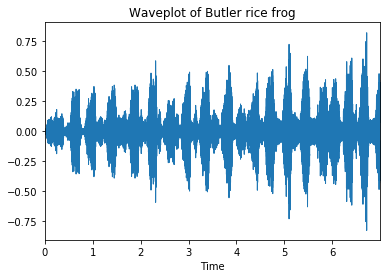

In [17]:
y, sr = librosa.load(fname, sr=SAMPLE_RATE)  
# plot a waveform  
plt.figure()  
librosa.display.waveplot(y, sr)  
plt.title('Waveplot of Butler rice frog')  
plt.show() 

## 2. Data Exploration
### MFCC Introduciton
But before the Deep Learning era, people developed techniques to extract features from audio signals. It turns out that these techniques are still useful. One such technique is computing the **MFCC** (**Mel Frquency Cepstral Coefficients**) from the raw audio. Before we jump to MFCC, let's talk about extracting features from the sound.

If we just want to classify some sound, we should build features that are speaker independent. Any feature that only gives information about the speaker (like the pitch of their voice) will not be helpful for classification. In other words, we should extract features that depend on the "content" of the audio rather than the nature of the speaker. Also, a good feature extraction technique should mimic the human speech perception. We don't hear loudness on a linear scale. If we want to double the perceived loudness of a sound, we have to put 8 times as much energy into it. Instead of a linear scale, our perception system uses a log scale.

Taking these things into account, Davis and Mermelstein came up with MFCC in the 1980's. MFCC mimics the logarithmic perception of loudness and pitch of human auditory system and tries to eliminate speaker dependent characteristics by excluding the fundamental frequency and their harmonics. The underlying mathematics is quite complicated and we will skip that. For those interested, here is the [detailed explanation](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/).

### Generating MFCC using Librosa
The library librosa has a function to calculate MFCC. Let's compute the MFCC of an audio file and visualize it.

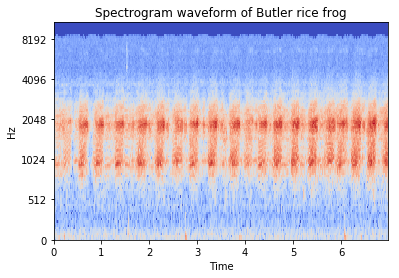

In [18]:
# extract mel spectrogram feature  
melspec = librosa.feature.melspectrogram(y, sr, n_fft=1024, hop_length=512, n_mels=128)  
# convert to log scale  
logmelspec = librosa.power_to_db(melspec)  
# plot mel spectrogram  
plt.figure()  
librosa.display.specshow(logmelspec, sr=sr, x_axis='time', y_axis='mel')  
plt.title('Spectrogram waveform of Butler rice frog')  
plt.show()

# 3. Feature Extraction

In [21]:
# Function from EDA kernel: https://www.kaggle.com/codename007/a-very-extensive-freesound-exploratory-analysis
SAMPLE_RATE = 44100


# Generate mfcc features with mean and standard deviation
def get_mfcc(name, path):
    data, _ = librosa.core.load(path + name, sr = SAMPLE_RATE)
    assert _ == SAMPLE_RATE
    try:
        ft1 = librosa.feature.mfcc(data, sr = SAMPLE_RATE, n_mfcc=30)
        ft2 = librosa.feature.zero_crossing_rate(data)[0]
        ft3 = librosa.feature.spectral_rolloff(data)[0]
        ft4 = librosa.feature.spectral_centroid(data)[0]
        ft5 = librosa.feature.spectral_contrast(data)[0]
        ft6 = librosa.feature.spectral_bandwidth(data)[0]
        ft1_trunc = np.hstack((np.mean(ft1, axis=1), np.std(ft1, axis=1), skew(ft1, axis = 1), np.max(ft1, axis = 1), np.median(ft1, axis = 1), np.min(ft1, axis = 1)))
        ft2_trunc = np.hstack((np.mean(ft2), np.std(ft2), skew(ft2), np.max(ft2), np.median(ft2), np.min(ft2)))
        ft3_trunc = np.hstack((np.mean(ft3), np.std(ft3), skew(ft3), np.max(ft3), np.median(ft3), np.min(ft3)))
        ft4_trunc = np.hstack((np.mean(ft4), np.std(ft4), skew(ft4), np.max(ft4), np.median(ft4), np.min(ft4)))
        ft5_trunc = np.hstack((np.mean(ft5), np.std(ft5), skew(ft5), np.max(ft5), np.median(ft5), np.min(ft5)))
        ft6_trunc = np.hstack((np.mean(ft6), np.std(ft6), skew(ft6), np.max(ft6), np.median(ft6), np.max(ft6)))
        return pd.Series(np.hstack((ft1_trunc, ft2_trunc, ft3_trunc, ft4_trunc, ft5_trunc, ft6_trunc)))
    except:
        print('bad file')
        return pd.Series([0]*210)

## 3.1 Import training and testing set

In [56]:
list = []
list_label = []
for i in audio_train_files:
    for j in os.listdir('./input/train/'+i):
        list.append('./input/train/'+i+'/'+j)
        list_label.append(i)

In [57]:
list

['./input/train/American_bull/American_bull_1.mp3',
 './input/train/American_bull/American_bull_2.mp3',
 './input/train/American_bull/American_bull_3.mp3',
 './input/train/Brauer_treefrog/Brauer_treefrog_1.mp3',
 './input/train/Brauer_treefrog/Brauer_treefrog_2.mp3',
 './input/train/Brauer_treefrog/Brauer_treefrog_3.mp3',
 './input/train/Brown_treefrog/Brown_treefrog_1.mp3',
 './input/train/Brown_treefrog/Brown_treefrog_2.mp3',
 './input/train/Brown_treefrog/Brown_treefrog_3.mp3',
 './input/train/Butler/Butler_1.mp3',
 './input/train/Butler/Butler_2.mp3',
 './input/train/Butler/Butler_3.mp3',
 './input/train/Chinese_bull/Chinese_bull_1.mp3',
 './input/train/Chinese_bull/Chinese_bull_2.mp3',
 './input/train/Chinese_bull/Chinese_bull_3.mp3',
 './input/train/Eiffinger/Eiffinger_1.mp3',
 './input/train/Eiffinger/Eiffinger_2.mp3',
 './input/train/Eiffinger/Eiffinger_3.mp3',
 './input/train/Emerald_treefrog/Emerald_treefrog_1.mp3',
 './input/train/Emerald_treefrog/Emerald_treefrog_2.mp3',
 '

In [58]:
list_label

['American_bull',
 'American_bull',
 'American_bull',
 'Brauer_treefrog',
 'Brauer_treefrog',
 'Brauer_treefrog',
 'Brown_treefrog',
 'Brown_treefrog',
 'Brown_treefrog',
 'Butler',
 'Butler',
 'Butler',
 'Chinese_bull',
 'Chinese_bull',
 'Chinese_bull',
 'Eiffinger',
 'Eiffinger',
 'Eiffinger',
 'Emerald_treefrog',
 'Emerald_treefrog',
 'Emerald_treefrog',
 'Farmland_treefrog',
 'Farmland_treefrog',
 'Farmland_treefrog',
 'Fujian',
 'Fujian',
 'Fujian',
 'Green_pond',
 'Green_pond',
 'Green_pond',
 'Gunther',
 'Gunther',
 'Gunther',
 'Harpist',
 'Harpist',
 'Harpist',
 'Heymon',
 'Heymon',
 'Heymon',
 'Japanese_Buerger',
 'Japanese_Buerger',
 'Japanese_Buerger',
 'Latouchte',
 'Latouchte',
 'Latouchte',
 'Long-legged',
 'Long-legged',
 'Long-legged',
 'Malaysian_narrow_mouthed_toad',
 'Malaysian_narrow_mouthed_toad',
 'Malaysian_narrow_mouthed_toad',
 'Mangrove',
 'Mangrove',
 'Mangrove',
 'Meintein_treefrog',
 'Meintein_treefrog',
 'Meintein_treefrog',
 'Moltrecht_treefrog',
 'Moltre

In [44]:
from pandas.core.frame import DataFrame
train= pd.DataFrame({'fname':list})
train.head(3)

,fname
0,./input/train/American_bull/American_bull_1.mp3
1,./input/train/American_bull/American_bull_2.mp3
2,./input/train/American_bull/American_bull_3.mp3


In [45]:
# Prepare data
test= pd.DataFrame()
test['fname'] = audio_test_files
test.head(3)

,fname
0,American_bull.mp3
1,Brauer_treefrog.mp3
2,Brown_treefrog.mp3


## 3.2 Get MFCC Feature

In [46]:
train_data = train['fname'].progress_apply(get_mfcc, path='')
print('done loading train mfcc')

100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:32<00:00,  2.14it/s]


done loading train mfcc


In [47]:
test_data = test['fname'].progress_apply(get_mfcc, path='./input/test/')
print('done loading test mfcc')

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:10<00:00,  3.14it/s]


done loading test mfcc


In [48]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,200,201,202,203,204,205,206,207,208,209
0,-185.626870,107.773062,-9.412176,46.641153,-31.253012,26.115716,0.744133,16.495057,12.095300,-9.613835,...,0.483725,56.217514,21.868216,7.609909,1755.634130,297.383212,1.100434,2821.509788,1779.288433,2821.509788
1,-195.072873,99.788209,-11.642722,49.751790,-28.479922,22.599232,1.311564,12.465465,14.097969,-8.353556,...,0.572481,46.891832,19.849689,4.215056,1742.007544,255.237957,-0.313128,2511.071686,1775.166780,2511.071686
2,-195.435655,95.834333,-9.764133,50.097389,-31.189363,25.782567,-0.952727,14.067266,13.743160,-8.822169,...,0.485833,42.862283,20.147110,6.800172,1735.180477,229.117519,-1.286225,2156.129104,1790.992430,2156.129104
3,-351.180896,92.030797,3.365146,27.404340,1.363635,15.229851,-5.241214,26.568170,-8.659925,16.669946,...,1.890191,55.455763,16.782203,6.849049,2283.199316,394.648729,-2.245359,2686.332541,2426.765128,2686.332541
4,-335.961219,97.862204,-1.966588,19.759717,0.298555,16.324489,-10.484668,28.557159,-5.482026,15.081584,...,0.944581,41.282867,16.070329,6.664607,2210.049721,466.759459,-1.683956,2850.640956,2379.579982,2850.640956


In [49]:
train_data['fname'] = train['fname']
test_data['fname'] = test['fname']

train_data.head()

## 3.3 Import Label

In [60]:
train_data['label'] = list_label

In [62]:
train_data.head(6)

,0,1,2,3,4,5,6,7,8,9,...,202,203,204,205,206,207,208,209,fname,label
0,-185.626870,107.773062,-9.412176,46.641153,-31.253012,26.115716,0.744133,16.495057,12.095300,-9.613835,...,21.868216,7.609909,1755.634130,297.383212,1.100434,2821.509788,1779.288433,2821.509788,./input/train/American_bull/American_bull_1.mp3,American_bull
1,-195.072873,99.788209,-11.642722,49.751790,-28.479922,22.599232,1.311564,12.465465,14.097969,-8.353556,...,19.849689,4.215056,1742.007544,255.237957,-0.313128,2511.071686,1775.166780,2511.071686,./input/train/American_bull/American_bull_2.mp3,American_bull
2,-195.435655,95.834333,-9.764133,50.097389,-31.189363,25.782567,-0.952727,14.067266,13.743160,-8.822169,...,20.147110,6.800172,1735.180477,229.117519,-1.286225,2156.129104,1790.992430,2156.129104,./input/train/American_bull/American_bull_3.mp3,American_bull
3,-351.180896,92.030797,3.365146,27.404340,1.363635,15.229851,-5.241214,26.568170,-8.659925,16.669946,...,16.782203,6.849049,2283.199316,394.648729,-2.245359,2686.332541,2426.765128,2686.332541,./input/train/Brauer_treefrog/Brauer_treefrog_...,Brauer_treefrog
4,-335.961219,97.862204,-1.966588,19.759717,0.298555,16.324489,-10.484668,28.557159,-5.482026,15.081584,...,16.070329,6.664607,2210.049721,466.759459,-1.683956,2850.640956,2379.579982,2850.640956,./input/train/Brauer_treefrog/Brauer_treefrog_...,Brauer_treefrog
5,-339.134375,91.821495,-4.832414,18.319089,-1.670939,17.740864,-10.920534,29.351932,-5.850003,15.627764,...,15.757561,6.071664,2247.162387,434.781621,-2.027829,2660.530527,2407.567393,2660.530527,./input/train/Brauer_treefrog/Brauer_treefrog_...,Brauer_treefrog


In [74]:
test_data['label'] = np.zeros((len(audio_test_files)))

## 3.4 Construct features set

In [66]:
#Functions from LightGBM baseline: https://www.kaggle.com/opanichev/lightgbm-baseline
X = train_data.drop(['label', 'fname'], axis=1)
X = X.values
labels = np.sort(np.unique(train_data.label.values))
num_class = len(labels)

In [67]:
print(X)
print(labels)
print(num_class)

[[-185.62687038  107.77306209   -9.41217579 ... 2821.50978794
  1779.2884334  2821.50978794]
 [-195.0728726    99.78820873  -11.64272192 ... 2511.07168598
  1775.16677989 2511.07168598]
 [-195.43565532   95.83433301   -9.76413327 ... 2156.12910445
  1790.99242997 2156.12910445]
 ...
 [-491.23365194  124.69649967  -40.58129874 ... 1819.42135295
  1576.05511042 1819.42135295]
 [-493.37719986  124.0856291   -42.16576502 ... 2185.46158767
  1584.43503764 2185.46158767]
 [-493.70972144  124.71532569  -43.28135378 ... 1772.11510879
  1563.92810369 1772.11510879]]
['American_bull' 'Brauer_treefrog' 'Brown_treefrog' 'Butler'
 'Chinese_bull' 'Eiffinger' 'Emerald_treefrog' 'Farmland_treefrog'
 'Fujian' 'Green_pond' 'Gunther' 'Harpist' 'Heymon' 'Japanese_Buerger'
 'Latouchte' 'Long-legged' 'Malaysian_narrow_mouthed_toad' 'Mangrove'
 'Meintein_treefrog' 'Moltrecht_treefrog' 'Olive' 'Orange_belly_treefrog'
 'Ornate_rice' 'Ota_treefrog' 'Rice_field' 'Sauter' 'Spot_legged_treefrog'
 'Stejneger' 'Swin

In [68]:
c2i = {}
i2c = {}
for i, c in enumerate(labels):
    c2i[c] = i
    i2c[i] = c
y = np.array([c2i[x] for x in train_data.label.values]) #label change to 0~40

In [69]:
print(c2i)
print(y)

{'American_bull': 0, 'Brauer_treefrog': 1, 'Brown_treefrog': 2, 'Butler': 3, 'Chinese_bull': 4, 'Eiffinger': 5, 'Emerald_treefrog': 6, 'Farmland_treefrog': 7, 'Fujian': 8, 'Green_pond': 9, 'Gunther': 10, 'Harpist': 11, 'Heymon': 12, 'Japanese_Buerger': 13, 'Latouchte': 14, 'Long-legged': 15, 'Malaysian_narrow_mouthed_toad': 16, 'Mangrove': 17, 'Meintein_treefrog': 18, 'Moltrecht_treefrog': 19, 'Olive': 20, 'Orange_belly_treefrog': 21, 'Ornate_rice': 22, 'Ota_treefrog': 23, 'Rice_field': 24, 'Sauter': 25, 'Spot_legged_treefrog': 26, 'Stejneger': 27, 'Swinhoe': 28, 'Taipei_grass': 29, 'Taipei_treefrog': 30, 'Wang_treefrog': 31}
[ 0  0  0  1  1  1  2  2  2  3  3  3  4  4  4  5  5  5  6  6  6  7  7  7
  8  8  8  9  9  9 10 10 10 11 11 11 12 12 12 13 13 13 14 14 14 15 15 15
 16 16 16 17 17 17 18 18 18 19 19 19 20 20 20 21 21 21 22 22 22 23 23 23
 24 24 24 25 25 25 26 26 26 27 27 27 28 28 28 29 29 29 30 30 30 31 31 31]


In [75]:
test_data.head()

,0,1,2,3,4,5,6,7,8,9,...,202,203,204,205,206,207,208,209,fname,label
0,-197.497693,94.166899,-9.851505,50.523880,-31.196895,26.309010,-1.740181,14.173310,12.769808,-8.660908,...,19.864017,6.489222,1740.009385,220.220583,-1.372644,2139.850646,1784.090391,2139.850646,American_bull.mp3,0.0
1,-335.187360,96.659564,-4.038187,18.507502,-0.787202,19.232543,-12.561485,29.248027,-5.067178,14.444097,...,15.931681,5.615737,2214.170688,451.097534,-1.806769,2674.019655,2389.045644,2674.019655,Brauer_treefrog.mp3,0.0
2,-222.136001,79.140926,-71.955361,20.130238,-10.042811,36.388659,-2.641557,27.134769,-8.703253,20.938951,...,15.191007,2.299903,1965.294492,343.383084,-3.801052,2743.500105,2051.338753,2743.500105,Brown_treefrog.mp3,0.0
3,-248.108204,101.729190,-152.926733,-31.371986,18.509398,21.121977,-10.034303,39.219167,11.330245,14.343940,...,13.247803,1.993315,957.628895,210.701870,0.968581,1966.370693,908.885698,1966.370693,Butler.mp3,0.0
4,-264.225890,171.189977,-100.376475,-20.036596,1.741782,-32.894847,-13.125443,-30.833401,-33.948660,-14.596739,...,20.708624,5.698764,771.918039,161.621475,-0.167050,1577.119443,805.891807,1577.119443,Chinese_bull.mp3,0.0


In [76]:
X_test = test_data.drop(['label', 'fname'], axis=1)
X_test = X_test.values

In [77]:
X_test

array([[-197.49769341,   94.16689915,   -9.85150514, ..., 2139.85064596,
        1784.09039071, 2139.85064596],
       [-335.18736038,   96.65956402,   -4.03818657, ..., 2674.01965505,
        2389.04564377, 2674.01965505],
       [-222.13600069,   79.14092577,  -71.95536091, ..., 2743.50010495,
        2051.33875337, 2743.50010495],
       ...,
       [-247.10407831,  132.6684588 ,  -31.35639585, ..., 2199.76120377,
        1730.31530091, 2199.76120377],
       [-237.05800045,  141.64464638,  -48.87486131, ..., 2466.96323301,
        1111.65247151, 2466.96323301],
       [-493.49755765,  123.55251881,  -41.82526136, ..., 2406.48271877,
        1571.72842669, 2406.48271877]])

In [78]:
print(X.shape)
print(X_test.shape)

(96, 210)
(32, 210)


# 4. Principal Components Analysis (PCA)
* We use **StardardScaler** to normalize the train & test date: **(X-mean)/STD**
* Construct covariance matrix
* Split covariance matrix as eigenvector and eigenvalues
* Select k eigenvalues and eigenvector，k: the dimension of new covariance matrix
* Use the k eigenvector to set up project matrix (W)
* Use the project matrix (W) transfer d dimension to k dimension

In [80]:
# Apply scaling for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

In [82]:
X_scaled

array([[ 1.54308481e+00,  2.57730399e-01,  9.54631080e-01, ...,
         1.12079280e+00,  1.94974545e-01,  1.12079280e+00],
       [ 1.42164243e+00,  8.59976780e-02,  9.03731107e-01, ...,
         5.02717733e-01,  1.87329956e-01,  5.02717733e-01],
       [ 1.41697831e+00,  9.60445006e-04,  9.46599582e-01, ...,
        -2.03964724e-01,  2.16682400e-01, -2.03964724e-01],
       ...,
       [-2.38594413e+00,  6.21708026e-01,  2.43366923e-01, ...,
        -8.74342056e-01, -1.81970143e-01, -8.74342056e-01],
       [-2.41350262e+00,  6.08569843e-01,  2.07210176e-01, ...,
        -1.45564429e-01, -1.66427568e-01, -1.45564429e-01],
       [-2.41777768e+00,  6.22112923e-01,  1.81752986e-01, ...,
        -9.68527692e-01, -2.04462570e-01, -9.68527692e-01]])

In [83]:
X_test_scaled

array([[ 1.39046775, -0.03490157,  0.9446058 , ..., -0.23637476,
         0.20388092, -0.23637476],
       [-0.37973735,  0.01870894,  1.07726289, ...,  0.82714336,
         1.32591478,  0.82714336],
       [ 1.07370573, -0.35806985, -0.47257385, ...,  0.96547733,
         0.69955677,  0.96547733],
       ...,
       [ 0.75270402,  0.79316343,  0.4538747 , ..., -0.11709422,
         0.10414219, -0.11709422],
       [ 0.88186127,  0.98621708,  0.05411188, ...,  0.41489882,
        -1.04331564,  0.41489882],
       [-2.41505   ,  0.59710407,  0.2149803 , ...,  0.29448352,
        -0.18999501,  0.29448352]])

In [84]:
X1 = train_data.drop(['label', 'fname'], axis=1)
X1.head(3)

,0,1,2,3,4,5,6,7,8,9,...,200,201,202,203,204,205,206,207,208,209
0,-185.626870,107.773062,-9.412176,46.641153,-31.253012,26.115716,0.744133,16.495057,12.095300,-9.613835,...,0.483725,56.217514,21.868216,7.609909,1755.634130,297.383212,1.100434,2821.509788,1779.288433,2821.509788
1,-195.072873,99.788209,-11.642722,49.751790,-28.479922,22.599232,1.311564,12.465465,14.097969,-8.353556,...,0.572481,46.891832,19.849689,4.215056,1742.007544,255.237957,-0.313128,2511.071686,1775.166780,2511.071686
2,-195.435655,95.834333,-9.764133,50.097389,-31.189363,25.782567,-0.952727,14.067266,13.743160,-8.822169,...,0.485833,42.862283,20.147110,6.800172,1735.180477,229.117519,-1.286225,2156.129104,1790.992430,2156.129104


## 4.1 PCA dimension Survey

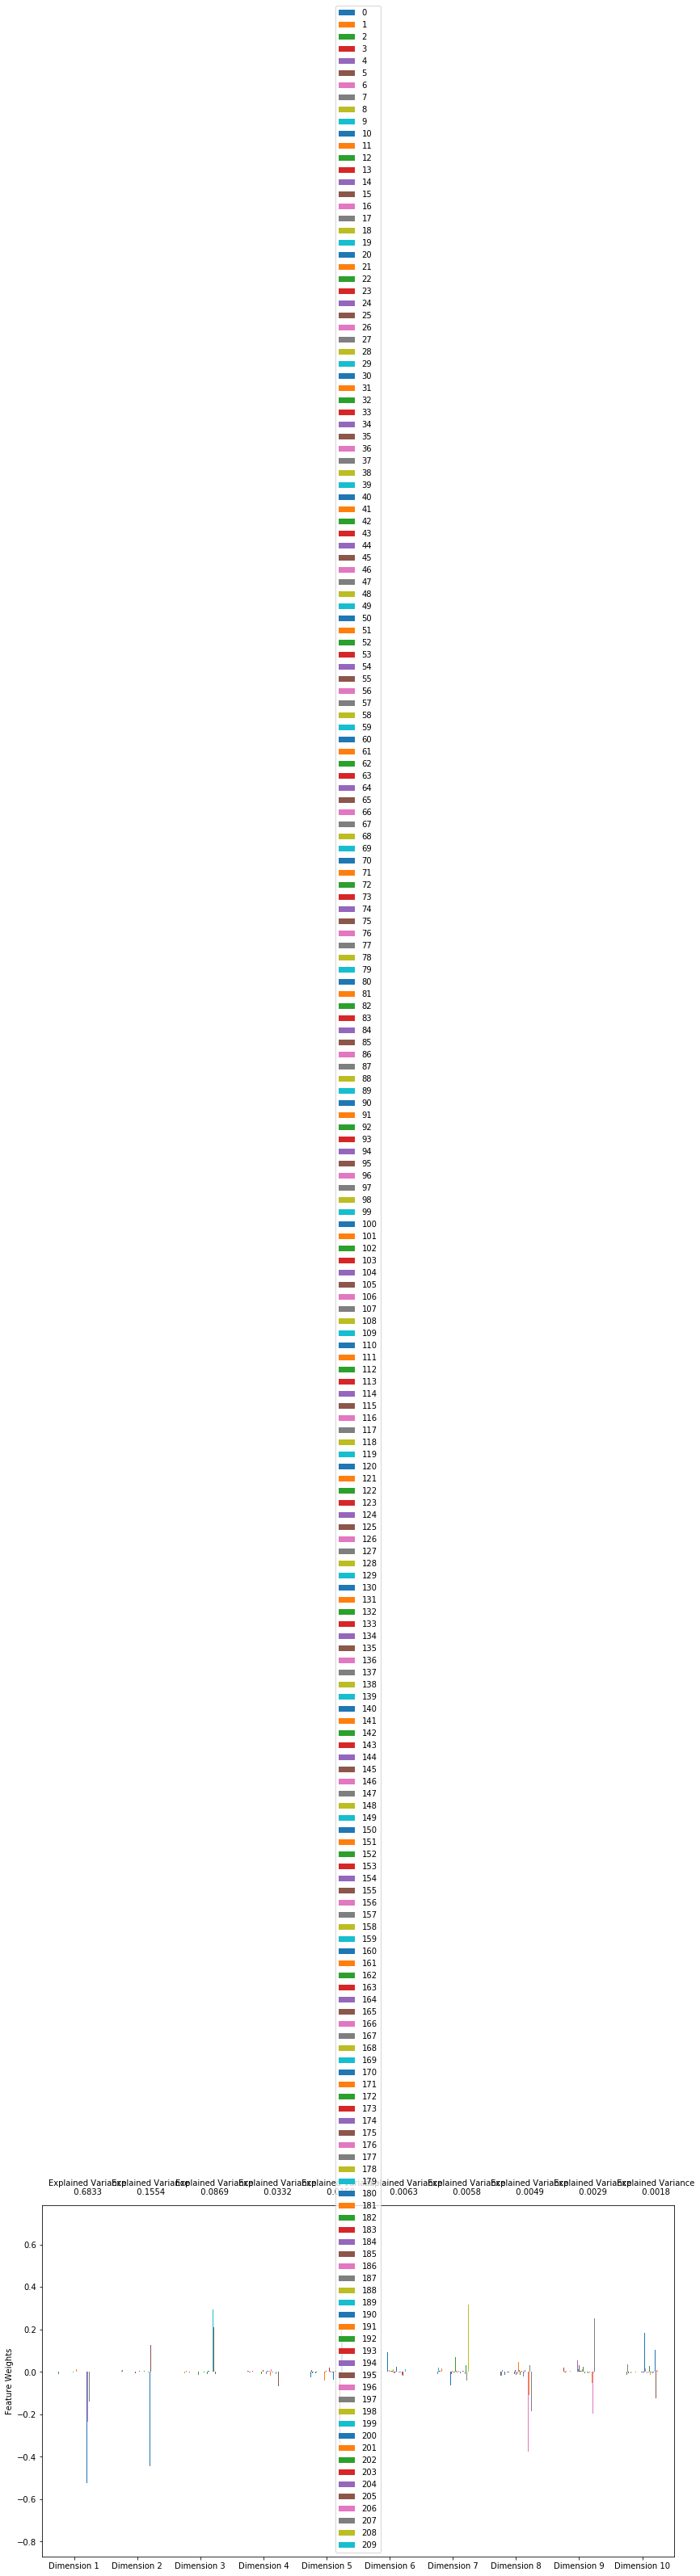

In [85]:
# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(X1)

# TODO: Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(X_scaled)

# Generate PCA results plot
import visualss as vs
pca_results = vs.pca_results(X1, pca)

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline
lista = range(1,70)
aa=[]
bb=[]
for f in lista:
    aa.append(f)
    pca = PCA(n_components=f).fit(X_scaled)
    #print(X_scaled)
    #bb.append(pca.explained_variance_ratio_)
    
a = 0
for e in lista:
    a=a+pca.explained_variance_ratio_[e-1]
    bb.append(a)   
#print(aa)
#print(bb)

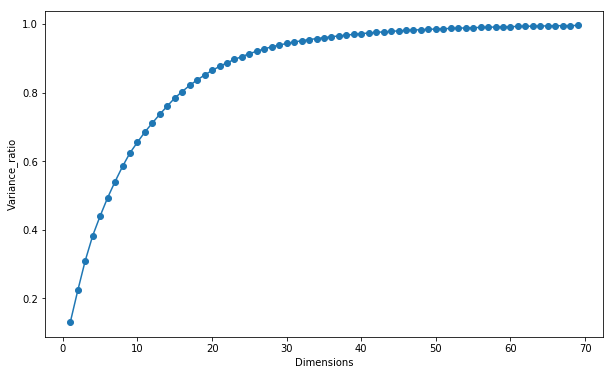

In [87]:
fig, ax = plt.subplots(figsize = (10,6))
plot = plt.plot(aa, bb, '-o')
ax.set_xlabel("Dimensions")
ax.set_ylabel("Variance_ratio"); 

## 4.2 PCA for dimension reduction
Based on PCA result, we reduce dimension from **209** to **60** in order to avoid overfit problem.

In [88]:
# Apply PCA for dimension reduction
pca = PCA(n_components=60).fit(X_scaled)
X_pca = pca.transform(X_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(sum(pca.explained_variance_ratio_)) 

0.9934426711680734


In [89]:
X_pca.shape

(96, 60)

In [90]:
y.shape

(96,)

In [91]:
X_pca

array([[-1.26064023e+00,  7.63513745e+00,  3.17139875e+00, ...,
         4.53773549e-01, -4.58375632e-01, -3.51785078e-01],
       [-2.10679368e-01,  6.61070761e+00,  3.63099504e+00, ...,
        -9.62727042e-02,  6.58742955e-03,  2.38296314e-01],
       [-9.82836146e-01,  6.24354929e+00,  4.04823459e+00, ...,
        -6.10772556e-01,  3.38213547e-02,  2.99029874e-01],
       ...,
       [-4.07721638e+00, -4.90664669e+00,  3.34433150e+00, ...,
        -1.48018174e-01,  2.33731152e-01, -7.21467467e-01],
       [-3.65447091e+00, -4.59923776e+00,  3.55597167e+00, ...,
         7.20475622e-02, -9.44917237e-02,  1.03069819e-01],
       [-3.97875814e+00, -4.94545063e+00,  3.29234220e+00, ...,
         6.97046060e-02,  2.53134383e-01,  4.41538489e-01]])

In [92]:
y

array([ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,
        5,  6,  6,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11,
       11, 11, 12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16,
       17, 17, 17, 18, 18, 18, 19, 19, 19, 20, 20, 20, 21, 21, 21, 22, 22,
       22, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 26, 27, 27, 27, 28,
       28, 28, 29, 29, 29, 30, 30, 30, 31, 31, 31])

# 5. Model Training

In [93]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split data to train & test sets
X_train, X_val, y_train, y_val = train_test_split(X_pca, y, test_size = 0.2)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [94]:
# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_val.shape[0]))

Training set has 76 samples.
Testing set has 20 samples.


## 5.1 Initial Model

In [96]:
from sklearn.metrics import accuracy_score
# Import 3 Classifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as LGB

SVM = SVC()
RFC = RandomForestClassifier()
XGB = XGBClassifier()
LGB = LGB.LGBMClassifier()

SVM.fit(X_train,y_train)
RFC.fit(X_train,y_train)
XGB.fit(X_train,y_train)
LGB.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [97]:
print ("accuracy_score on testing data of SVM: {:.4f}".format(accuracy_score(y_val, SVM.predict(X_val))))
print ("accuracy_score on testing data of Random Forst: {:.4f}".format(accuracy_score(y_val, RFC.predict(X_val))))
print ("accuracy_score on testing data of XGBoost: {:.4f}".format(accuracy_score(y_val, XGB.predict(X_val))))
print ("accuracy_score on testing data of LightLGB: {:.4f}".format(accuracy_score(y_val, LGB.predict(X_val))))

accuracy_score on testing data of SVM: 0.8000
accuracy_score on testing data of Random Forst: 0.6000


C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy_score on testing data of XGBoost: 0.7500


C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy_score on testing data of LightLGB: 0.8500


# 6. Model Tuning
## 6.1 SVM

In [99]:
param_grid_S = {'C': [0.1, 1, 10],'gamma' : [0.01, 0.1, 1]}

gridS = GridSearchCV(SVC(kernel='rbf'), param_grid=param_grid_S, cv = 3, scoring = "accuracy")
gridS.fit(X_train, y_train)

# Find the best model
print(gridS.best_score_)
print(gridS.best_params_)
print(gridS.best_estimator_)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


0.9473684210526315
{'C': 10, 'gamma': 0.01}
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [100]:
from matplotlib.colors import Normalize
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [101]:
gridS.cv_results_['mean_test_score']

array([0.63157895, 0.5       , 0.48684211, 0.89473684, 0.5       ,
       0.43421053, 0.94736842, 0.52631579, 0.43421053])

In [104]:
scores = gridS.cv_results_['mean_test_score'].reshape(3,3)
print(scores)

[[0.63157895 0.5        0.48684211]
 [0.89473684 0.5        0.43421053]
 [0.94736842 0.52631579 0.43421053]]


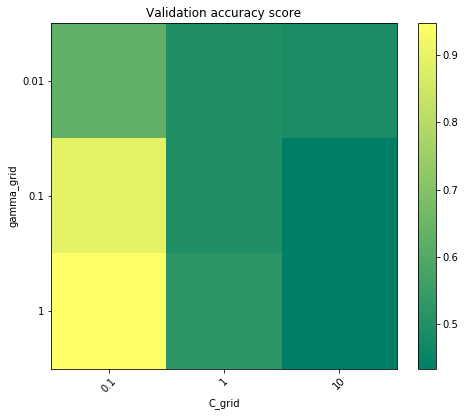

In [109]:
C_grid = [0.1, 1, 10]
gamma_grid = [0.01, 0.1, 1]
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
scores = gridS.cv_results_['mean_test_score'].reshape(3,3)
plt.imshow(scores, interpolation='nearest', cmap='summer')
plt.xlabel('C_grid')
plt.ylabel('gamma_grid')
plt.colorbar()
plt.xticks(np.arange(3), C_grid, rotation=45)
plt.yticks(np.arange(3), gamma_grid)
plt.title('Validation accuracy score')
plt.show()

## Optimal SVM Model

In [126]:
SVM = SVC(kernel = 'rbf', C = 10, gamma = 0.01, probability=True)
SVM.fit(X_train, y_train)
print(accuracy_score(SVM.predict(X_val), y_val))

1.0


## 6.2 Random Forst

In [114]:
rfc=RandomForestClassifier(random_state=42)
param_grid_R = { 
    'n_estimators': [150, 300, 450],
    'min_samples_split' : [2,4,6]}

gridR = GridSearchCV(estimator=rfc, param_grid=param_grid_R, cv= 3)
gridR.fit(X_train, y_train)

# Find the best model
print(gridR.best_score_)
print(gridR.best_params_)
print(gridR.best_estimator_)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


0.9078947368421053
{'min_samples_split': 2, 'n_estimators': 300}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)


In [116]:
scores = gridR.cv_results_['mean_test_score'].reshape(3,3)
print(scores)

[[0.88157895 0.90789474 0.89473684]
 [0.86842105 0.88157895 0.88157895]
 [0.81578947 0.82894737 0.84210526]]


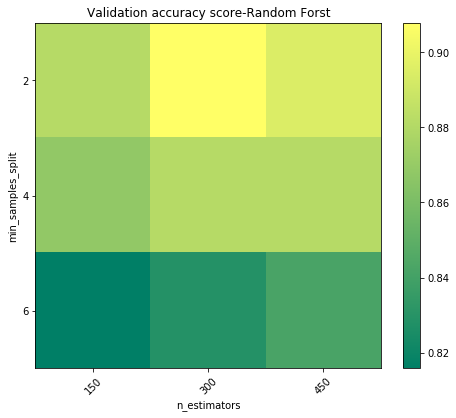

In [117]:
n_estimators = [150, 300, 450]
min_samples_split = [2,4,6]
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
scores = gridR.cv_results_['mean_test_score'].reshape(3,3)
plt.imshow(scores, interpolation='nearest', cmap='summer')
plt.xlabel('n_estimators')
plt.ylabel('min_samples_split')
plt.colorbar()
plt.xticks(np.arange(3), n_estimators, rotation=45)
plt.yticks(np.arange(3), min_samples_split)
plt.title('Validation accuracy score-Random Forst')
plt.show()

## Optimal RF Model

In [119]:
RFC = RandomForestClassifier(min_samples_split = 2, n_estimators=300)
RFC.fit(X_train, y_train)
print(accuracy_score(RFC.predict(X_val), y_val))

0.95


## 6.3 XGBoost

In [127]:
parameters_XGB = {'learning_rate': [0.1,0.3,0.5],  #0.2
                  'max_depth': [6,12,24], #10 ***
                 }

gridX = GridSearchCV(XGB, parameters_XGB, scoring = "accuracy")
gridX.fit(X_train, y_train)

# Find the best model
print(gridX.best_score_)
print(gridX.best_params_)
print(gridX.best_estimator_)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in f

C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

0.8552631578947368
{'learning_rate': 0.1, 'max_depth': 6}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


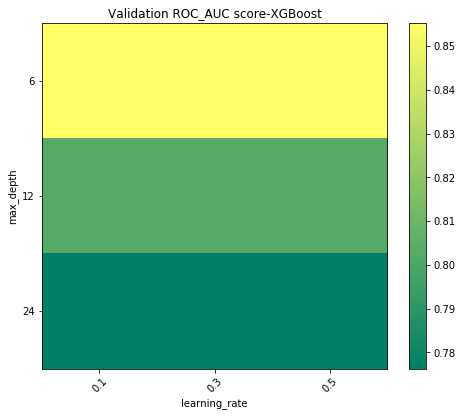

In [129]:
learning_rate = [0.1,0.3,0.5]
max_depth = [6,12,24]
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
scoresX = gridX.cv_results_['mean_test_score'].reshape(3,3)
plt.imshow(scoresX, interpolation='nearest', cmap='summer')
plt.xlabel('learning_rate')
plt.ylabel('max_depth')
plt.colorbar()
plt.xticks(np.arange(3), learning_rate, rotation=45)
plt.yticks(np.arange(3), max_depth)
plt.title('Validation ROC_AUC score-XGBoost')
plt.show()

In [130]:
# Optimal model
XGB = XGBClassifier(learning_rate=0.1, max_depth=6)
XGB.fit(X_train, y_train)
print(accuracy_score(XGB.predict(X_val), y_val))

C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.75


## 6.4 LightGBM

In [131]:
parameters_LGB = {
    'learning_rate': [0.1,0.3,0.5], # 0.1
    'num_leaves': [21,31,41] #31
    }

gridL = GridSearchCV(LGB, parameters_LGB, scoring = "accuracy")
gridL.fit(X_train, y_train)

# Find the best model
print(gridL.best_score_)
print(gridL.best_params_)
print(gridL.best_estimator_)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in f

C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

0.8552631578947368
{'learning_rate': 0.1, 'num_leaves': 21}
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=21, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


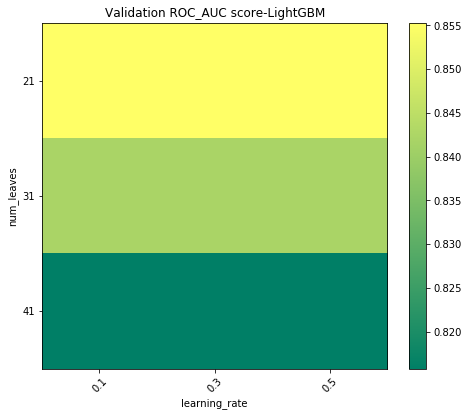

In [132]:
learning_rate = [0.1,0.3,0.5] # 0.1
num_leaves = [21,31,41] #31
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
scoresL = gridL.cv_results_['mean_test_score'].reshape(len(learning_rate),len(num_leaves))
plt.imshow(scoresL, interpolation='nearest', cmap='summer')
plt.xlabel('learning_rate')
plt.ylabel('num_leaves')
plt.colorbar()
plt.xticks(np.arange(len(learning_rate)), learning_rate, rotation=45)
plt.yticks(np.arange(len(num_leaves)), num_leaves)
plt.title('Validation ROC_AUC score-LightGBM')
plt.show()

In [133]:
# Optimal model
from lightgbm import LGBMClassifier
LGB = LGBMClassifier(learning_rate = 0.3, num_leaves = 31)
LGB.fit(X_train, y_train)
print(accuracy_score(LGB.predict(X_val), y_val))

C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.85


# 7. Conculsion

| Model | Initial Model  | Model turning | Test |
| :--: |
| SVM | 0.8 | 0.94 | 0.99 |
| Random Forst | 0.6 | 0.90 | 0.95 |
| XGBoost | 0.75 | 0.85 | 0.75 |
| LightGBM | 0.85 | 0.85 | 0.85 |